In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
!tar xf spark-3.0.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
#@title
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
# dataframe functions
from pyspark.sql import functions as fn
from pyspark.ml import feature, regression, Pipeline, pipeline, evaluation, tuning, clustering
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

In [ ]:
df = spark.read.csv('acceptedloansdata.csv', header=True, sep=",", inferSchema=True)

In [ ]:
# training data: include all features except good/bad loans

In [ ]:
df.toPandas()

,_c0,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,Month
0,0,15000.0,15000.0,15000.0,60.0,0.1239,336.64,C,C1,MANAGEMENT,...,100.0,0.0,0.0,0.0,196500.0,149140.0,10000.0,12000.0,N,December
1,1,10400.0,10400.0,10400.0,36.0,0.0699,321.08,A,A3,Truck Driver Delivery Personel,...,83.3,14.3,0.0,0.0,179407.0,15030.0,13000.0,11325.0,N,December
2,2,12800.0,12800.0,12800.0,60.0,0.1714,319.08,D,D4,Senior Sales Professional,...,76.9,100.0,0.0,0.0,368700.0,18007.0,4400.0,18000.0,N,December
3,3,21425.0,21425.0,21425.0,60.0,0.1559,516.36,D,D1,Programming Analysis Supervisor,...,91.4,100.0,0.0,0.0,57073.0,42315.0,15000.0,35573.0,N,December
4,4,9600.0,9600.0,9600.0,36.0,0.1366,326.53,C,C3,Admin Specialist,...,100.0,60.0,0.0,0.0,52490.0,38566.0,21100.0,24890.0,N,December
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235624,235624,18400.0,18400.0,18400.0,60.0,0.1447,432.64,C,C2,Financial Advisor,...,100.0,80.0,0.0,0.0,311049.0,184117.0,21200.0,159744.0,N,January
235625,235625,22000.0,22000.0,22000.0,60.0,0.1997,582.50,D,D5,Chief of Interpretation (Park Ranger),...,100.0,20.0,1.0,0.0,263367.0,47136.0,12200.0,39347.0,N,January
235626,235626,2000.0,2000.0,2000.0,36.0,0.0790,62.59,A,A4,Server Engineer Lead,...,85.2,11.1,0.0,0.0,640841.0,50896.0,47500.0,37200.0,N,January
235627,235627,20700.0,20700.0,20700.0,60.0,0.1699,514.34,D,D1,patrol,...,97.6,100.0,0.0,0.0,96582.0,73598.0,8500.0,83482.0,N,January


In [ ]:
#1. dummy variables for loans charged off/late
from pyspark.ml.feature import StringIndexer
df.select('loan_status')
indexer=StringIndexer(inputCol='loan_status', outputCol='encodedstatus')



In [ ]:
df = df.filter((df.loan_status != 'Current'))

In [ ]:
df2 = indexer.fit(df).transform(df)
df = df2.withColumn('label', fn.when(fn.col('encodedstatus') > 0, 1.0).otherwise(0.))

+-----+---------------+
|label|    loan_status|
+-----+---------------+
|  0.0|     Fully Paid|
|  1.0|    Charged Off|
|  1.0|In Grace Period|
|  0.0|     Fully Paid|
|  0.0|     Fully Paid|
|  1.0|    Charged Off|
|  0.0|     Fully Paid|
|  0.0|     Fully Paid|
|  1.0|    Charged Off|
|  0.0|     Fully Paid|
|  1.0|    Charged Off|
|  1.0|    Charged Off|
|  0.0|     Fully Paid|
|  0.0|     Fully Paid|
|  0.0|     Fully Paid|
|  0.0|     Fully Paid|
|  0.0|     Fully Paid|
|  0.0|     Fully Paid|
|  0.0|     Fully Paid|
|  0.0|     Fully Paid|
+-----+---------------+
only showing top 20 rows



In [ ]:
training_df, validation_df, testing_df = df.randomSplit([0.6, 0.3, 0.1])

# Logistic Regression

In [ ]:
va = VectorAssembler().setInputCols(['out_prncp_inv', 'total_pymnt_inv', 'recoveries', 'total_acc', 'last_pymnt_amnt', 'total_rec_int', 'emp_length', 'dti', 'loan_amnt', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'revol_bal', 'total_acc']).setOutputCol('features')

In [ ]:
lr = LogisticRegression()

In [ ]:
model = Pipeline(stages=[va, lr]).fit(training_df)

In [ ]:
pd.DataFrame(list(zip(va.getInputCols(), model2.stages[-1].coefficients.toArray())),
            columns = ['column', 'weight']).sort_values('weight', ascending=False)

,column,weight
1,int_rate,0.095393
6,addr_state,0.086446
3,emp_length,0.028280
5,purpose,0.013957
0,dti,-0.025526
2,loan_amnt,-0.037932
4,Month,-0.084831


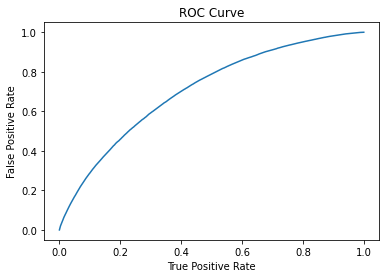

Training set areaUnderROC: 0.7067222325830119


In [ ]:
trainingSummary = model.stages[-1].summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

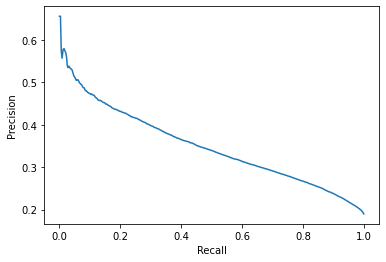

In [ ]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [ ]:
predictions = model.transform(validation_df)
predictions.groupBy('prediction').count()

DataFrame[prediction: double, count: bigint]

# Random Forest

In [ ]:
rf = RandomForestClassifier()

In [ ]:
rf_pipeline = Pipeline(stages=[features, rf]).fit(training_df)

In [ ]:
rf_model = rf_pipeline.stages[-1]

In [ ]:
pd.DataFrame(list(zip(feature_list, rf_model.featureImportances.toArray())),
            columns = ['column', 'weight']).sort_values('weight')

,column,weight
2,loan_amnt,0.000000
3,emp_length,0.000000
4,Month,0.000000
5,purpose,0.000000
1,int_rate,0.000382
0,dti,0.000798
6,addr_state,0.001451


In [ ]:
len(rf_model.trees)

20

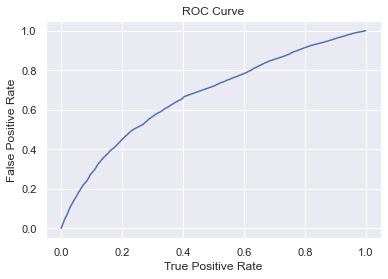

Training set areaUnderROC: 0.6720656717629347


In [ ]:
rftrainingSummary = rf_model.summary
roc = rftrainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(rftrainingSummary.areaUnderROC))

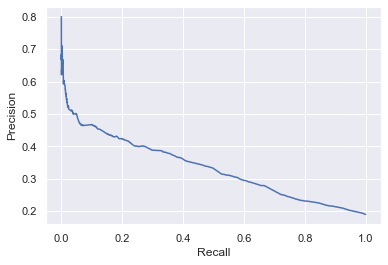

In [ ]:
pr = rftrainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [ ]:
print(rf_model.trees[0].toDebugString)

DecisionTreeClassificationModel: uid=dtc_7420335f4b0e, depth=5, numNodes=19, numClasses=2, numFeatures=75
  If (feature 57 in {1.0})
   If (feature 74 <= 1.7066778997070506)
    If (feature 72 <= 4.5079200326509286)
     If (feature 71 <= 4.157777098130314)
      Predict: 0.0
     Else (feature 71 > 4.157777098130314)
      If (feature 61 in {1.0})
       Predict: 0.0
      Else (feature 61 not in {1.0})
       Predict: 1.0
    Else (feature 72 > 4.5079200326509286)
     If (feature 31 in {1.0})
      Predict: 1.0
     Else (feature 31 not in {1.0})
      Predict: 0.0
   Else (feature 74 > 1.7066778997070506)
    If (feature 19 in {1.0})
     Predict: 1.0
    Else (feature 19 not in {1.0})
     If (feature 28 in {1.0})
      If (feature 62 in {0.0})
       Predict: 0.0
      Else (feature 62 not in {0.0})
       Predict: 1.0
     Else (feature 28 not in {1.0})
      Predict: 0.0
  Else (feature 57 not in {1.0})
   Predict: 0.0



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

dft = rf_pipeline.transform(testing_df)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = evaluator.evaluate(dft)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

In [ ]:
dft.select('label', 'prediction').show()

In [ ]:
ra =spark.read.csv("combined.csv", inferSchema=True, header=True)

In [ ]:
from pyspark.ml.feature import StringIndexer
indexer=StringIndexer(inputCol='class', outputCol='elabel')

In [ ]:
ra2 = indexer.fit(ra).transform(ra)
ra = ra2.withColumn('label', fn.when(fn.col('elabel') == 1.0, 0.).otherwise(1.0))

In [ ]:
features_list = [
 'Debt-To-Income Ratio', 'Amount Requested',  'Employment Length', 'Month', 'Loan Title', 'State']

In [ ]:
training_df, validation_df, testing_df = ra.randomSplit([0.5, 0.4, 0.1])

In [ ]:
features2 = Pipeline(stages=[feature.VectorAssembler(inputCols= ['Debt-To-Income Ratio', 'Amount Requested',  'Employment Length'], outputCol='nfeatures'),
                                        feature.StandardScaler(inputCol='nfeatures', outputCol='scaled_features'),
                                        feature.StringIndexer(inputCol='Month', outputCol='smonth'),
                                        feature.OneHotEncoder(inputCol='smonth', outputCol='encoded_month'), 
                                        feature.StringIndexer(inputCol='Loan Title', outputCol='spurpose'), 
                                        feature.OneHotEncoder(inputCol='spurpose', outputCol='encoded_purpose'), 
                                        feature.StringIndexer(inputCol='State', outputCol='sstate'), 
                                        feature.OneHotEncoder(inputCol='sstate', outputCol='encoded_state'), 
                                        feature.VectorAssembler(inputCols=['encoded_state','encoded_purpose', 'encoded_month','scaled_features'], outputCol='features')])
            

In [ ]:
rf_pipeline = Pipeline(stages=[features2, rf]).fit(training_df)

In [ ]:
rf_model = rf_pipeline.transform(testing_df)

In [ ]:
rf_model.select('label', 'prediction').show()

# PCA

In [ ]:
pipeline = Pipeline(stages=[feature.VectorAssembler(inputCols= ['dti', 'int_rate', 'loan_amnt', 'emp_length'], outputCol='nfeatures'),
                                        feature.StandardScaler(inputCol='nfeatures', outputCol='scaled_features'),
                                        feature.StringIndexer(inputCol='Month', outputCol='smonth'), 
                                        feature.StringIndexer(inputCol='pymnt_plan', outputCol='encoded_pymnt_plan'),
                                        feature.OneHotEncoder(inputCol='smonth', outputCol='encoded_month'), 
                                        feature.StringIndexer(inputCol='purpose', outputCol='spurpose'), 
                                        feature.OneHotEncoder(inputCol='spurpose', outputCol='encoded_purpose'), 
                                        feature.StringIndexer(inputCol='addr_state', outputCol='sstate'), 
                                        feature.OneHotEncoder(inputCol='sstate', outputCol='encoded_state'), 
                                        feature.VectorAssembler(inputCols=['encoded_state','encoded_purpose', 'encoded_month','scaled_features'], outputCol='features'),
                                        feature.PCA(k=12, inputCol='features', outputCol='pca_feat')]).fit(df)

In [ ]:
sumValues = pipeline.stages[-1].explainedVariance.cumsum()

Text(0, 0.5, '% Variance Explained')

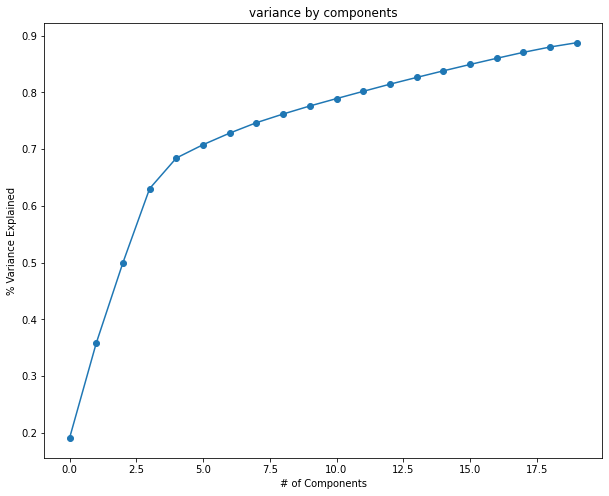

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(sumValues, marker='o')
plt.title('variance by components')
plt.xlabel('# of Components')
plt.ylabel('% Variance Explained')

In [ ]:
sumValues = pipeline.stages[-1].explainedVariance

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(sumValues, marker='o')
plt.title('variance by components')
plt.xlabel('# of Components')
plt.ylabel('Individual Variance Explained')

In [ ]:
from pyspark.sql import types, Row, functions as fn
@fn.udf(returnType=types.ArrayType(types.FloatType()))
def to_array(col):
    return col.toArray().tolist()

In [ ]:
pca_2d = pipeline.transform(df).select('label', 'grade', to_array('pca_feat').alias('pc_array')).select('label', 'grade', fn.expr('pc_array[0]').alias('pc1'), fn.expr('pc_array[1]').alias('pc2'))
pca_2d = pca_2d.toPandas()
pca_2d.head()

,label,grade,pc1,pc2
0,0.0,C,4.371202,0.839027
1,1.0,A,3.161410,0.534596
2,1.0,D,4.589806,0.602925
3,0.0,D,5.106226,-0.061978
4,0.0,C,5.074887,-0.417223


<AxesSubplot:xlabel='pc1', ylabel='pc2'>

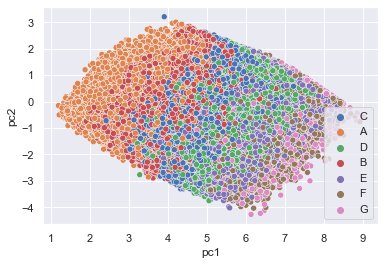

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")
sns.scatterplot(data=pca_2d, x='pc1', y='pc2', palette= "deep", hue=pca_2d.grade.tolist())

# KMeans

In [ ]:
kmeans = Pipeline(stages=[pipeline, 
                         clustering.KMeans(k=4, featuresCol='features', predictionCol='cluster')]).fit(df)

In [ ]:
kmeans.transform(df).where(fn.col('label') == 1).first()[-1]

1

In [ ]:
pca_2d = kmeans.transform(df).select('Cluster', 'label', 'grade', to_array('pca_feat').alias('pc_array')).select('Cluster', 'label', 'grade', fn.expr('pc_array[0]').alias('pc1'), fn.expr('pc_array[1]').alias('pc2'))
pca_2d = pca_2d.toPandas()
pca_2d.head()

,Cluster,label,grade,pc1,pc2
0,1,0.0,C,4.371202,0.839027
1,1,1.0,A,3.161410,0.534596
2,1,1.0,D,4.589806,0.602925
3,0,0.0,D,5.106226,-0.061978
4,3,0.0,C,5.074887,-0.417223


/Users/courtneyhrdy/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'K=4')

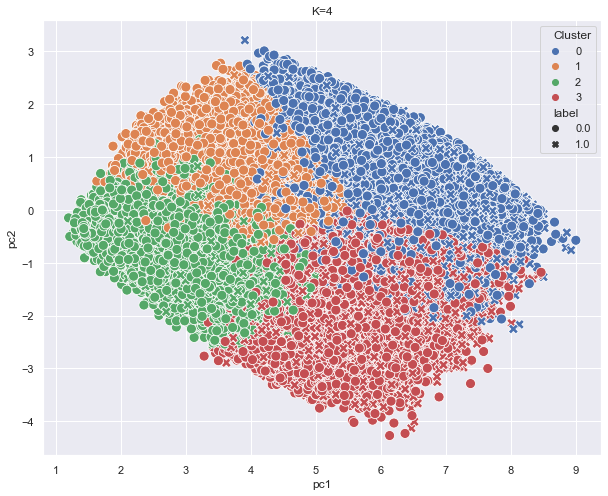

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
x=pca_2d['pc1']
y=pca_2d['pc2']
n=pca_2d['label']

plt.figure(figsize=(10,8))
sns.scatterplot(x, y, hue=pca_2d['Cluster'], style=n, palette= 'deep', s=100)
plt.title('K=4')

In [ ]:
pca_2d['']

,Cluster,label,grade,pc1,pc2
0,1,0.0,C,4.371202,0.839027
1,1,1.0,A,3.161410,0.534596
2,1,1.0,D,4.589806,0.602925
3,0,0.0,D,5.106226,-0.061978
4,3,0.0,C,5.074887,-0.417223
...,...,...,...,...,...
214061,3,0.0,C,4.833136,-0.622167
214062,0,1.0,D,6.271979,0.261950
214063,2,0.0,A,1.768336,-0.265614
214064,3,0.0,D,5.947888,-0.538644


In [ ]:
df1 = pipeline.transform(df)
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,11):

    KMeans_=KMeans(featuresCol='features', k=K)

    KMeans_fit=KMeans_.fit(df1)

    KMeans_transform=KMeans_fit.transform(df1) 

    evaluation_score=evaluator.evaluate(KMeans_transform)

    silhouette_scores.append(evaluation_score)

Text(0, 0.5, 'Silhouette Score')

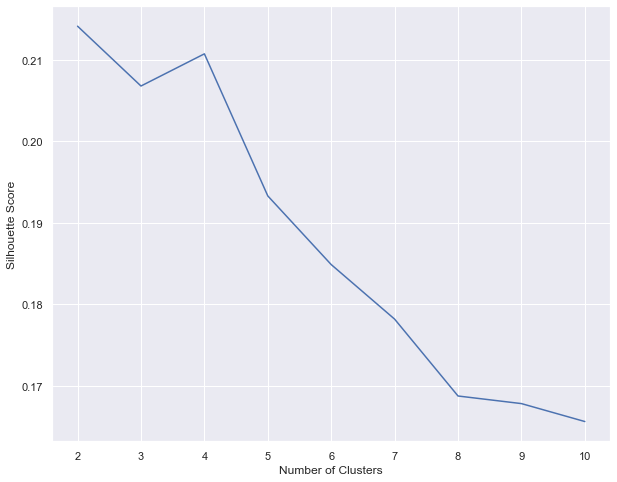

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')